In [2]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import torch
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from transformers import BertModel, BertTokenizer
from sklearn.metrics import accuracy_score, roc_curve, auc
import torch.nn.functional as F
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


/home/ege/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-24 15:49:26.322497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = set(stopwords.words('english'))
    stop = [w for w in stop if w not in ['not', 'no']]
    text = [x for x in text if (x not in stop)]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    
    return text


In [5]:
train = pd.read_csv('train_data_400k_randomsample.csv')
train["sentences"] = train["sentences"].apply(clean_text)
X = train.sentences.values
y = train.labels.values


In [6]:
X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2023)

#### Selecting which pre-trained BERT model we will use

In [7]:
# Load a pre-trained BERT model
model_name = 'bert-base-uncased'
bert_model = BertModel.from_pretrained(model_name)

# Load the corresponding tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Dedicating the BERT tokenization along with a preprocessing function

In [8]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=clean_text(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

#### Tokenizing and encoding each row in train and validation data. 

In [9]:
# Concatenate train data and test data
all_tweets = np.concatenate([X_train, X_val])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  312


In [10]:
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  mini chopper great handy little chopper heep counter top use almost every day price can't ask better chopper enjoying
Token IDs:  [101, 7163, 28057, 2307, 18801, 2210, 28057, 18235, 2361, 4675, 2327, 2224, 2471, 2296, 2154, 3976, 2064, 1005, 1056, 3198, 2488, 28057, 9107, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#### Pre-Trained BERT model is not directly appliable to spesific purposes such as sentiment analysis. Fine tunning allows us to adapt the pre-trained BERT model to perform well on spesific task by training it to task-spesific labeled data. 

In [11]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

#### This code defines a BertClassifier class that utilizes the BERT model for classification tasks. Let's break down the code and explain what is happening:

* Class Definition:

        The BertClassifier class is defined, inheriting from nn.Module.
        The __init__ method initializes the class and defines its components.
        It takes an optional argument freeze_bert (defaulted to False), which determines whether to freeze the BERT model during fine-tuning.
        It defines the input size D_in, hidden size H, and number of output labels D_out for the classifier.

* Model Initialization:

        The BERT model is instantiated using BertModel.from_pretrained('bert-base-uncased'). This loads the pre-trained BERT model with a base uncased configuration.
        The classifier is defined as a sequential neural network with two linear layers and a ReLU activation function.
        
* Freezing the BERT Model:
        
        If freeze_bert is set to True, the BERT model's parameters are frozen by setting requires_grad = False for each parameter.

* Forward Pass:

        The forward method takes input tensors input_ids and attention_mask and performs the forward pass of the model.
        The input tensors are fed into the BERT model using self.bert, which returns outputs including the last hidden state of each input token.
        The last hidden state of the special token [CLS] is extracted from the outputs (outputs[0][:, 0, :]), which represents the aggregated representation of the input sequence for classification.
        The extracted representation is then passed through the classifier (self.classifier) to compute the logits.
        Overall, this code sets up a BERT-based classifier for classification tasks, allowing for fine-tuning by training the classifier while optionally freezing the BERT model.

In [12]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 29 µs, sys: 0 ns, total: 29 µs
Wall time: 31.5 µs


The code snippet defines a function initialize_model that initializes a BERT classifier model, an optimizer, and a learning rate scheduler. Let's break down the code and explain what each step does:

In [13]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler


1- Initialization and Setup:

        The model, training dataloader, and optional validation dataloader are passed as input.
        The number of epochs is specified (default is 4).
        The training loop begins, and the header for the result table is printed.

2- Training Loop:

        For each epoch:
            The training loss, validation loss, validation accuracy, and elapsed time are printed for each batch.
            The total loss, batch loss, and batch count variables are initialized/reset.
            The model is put into training mode using model.train().
            For each batch in the training dataloader:
            The batch data is loaded onto the GPU.
            Gradients are zeroed using model.zero_grad().
            A forward pass is performed, and logits (raw predictions) are obtained using model(b_input_ids, b_attn_mask).
            The loss is computed using the provided loss function (loss_fn) and accumulated.
            Backward pass is performed to calculate gradients using loss.backward().
            The norm of the gradients is clipped to prevent exploding gradients using torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0).
            Model parameters are updated using optimizer.step().
            Learning rate is updated using the scheduler (scheduler.step()).
            Training loss and time elapsed are printed every 20 batches.
            Batch tracking variables are reset.
            The average training loss over the entire training data is calculated.

3- Evaluation:

            If evaluation is set to True:
            The model's performance on the validation set is measured using the evaluate function.
            Validation loss and accuracy are obtained.
            Training and validation results are printed, along with the time elapsed.
            The loop continues to the next epoch.

4- Completion:

            After the training loop completes, a "Training complete!" message is printed.

In [14]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

#### We are training the BERT model. 

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)

train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is depreca

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


: 

: 

In [ ]:

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9828
Accuracy: 93.95%


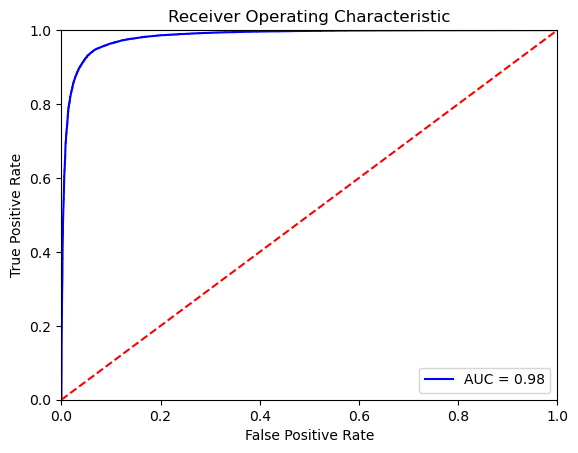

: 

In [ ]:
# # Compute predicted probabilities on the test set
# probs = bert_predict(bert_classifier, val_dataloader)

# pd.DataFrame(probs).to_csv("probs_bert.csv")

# # Evaluate the Bert classifier
# evaluate_roc(probs, y_val)

In [ ]:
test = pd.read_csv("test_data_44k.csv")
X_test = test.sentences.values
y_test = test.labels.values
test_inputs, test_masks = preprocessing_for_bert(X_test)
test_labels = torch.tensor(y_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)
pd.DataFrame(probs).to_csv("probs_bert.csv")

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)


In [28]:
# first let's look at the examples that svm got wrong
binary_preds = np.where(probs[:, 1] >= 0.5, 1, 0)
binary_preds

array([1, 0, 0, ..., 1, 0, 1])

In [37]:
acc_score = accuracy_score(test["labels"].values, binary_preds)
f1_score_val = f1_score(test["labels"].values, binary_preds)
prec_score = precision_score(test["labels"].values, binary_preds)
rec_score = recall_score(test["labels"].values, binary_preds)

print("Accuracy score: ", acc_score)
print("F1 score: ", f1_score_val)
print("Precision score: ", prec_score)
print("Recall score: ", rec_score)


Accuracy score:  0.9395454545454546
F1 score:  0.9391610630803715
Precision score:  0.9429568731915675
Recall score:  0.9353956900086564


#### Error Analysis

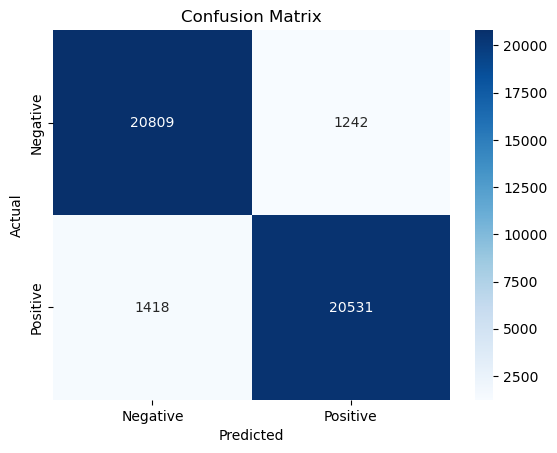

In [34]:
import seaborn as sns
#Show confusion matrix
cm = confusion_matrix(test["labels"], binary_preds)
cm = pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Negative", "Positive"])
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


<AxesSubplot: xlabel='labels'>

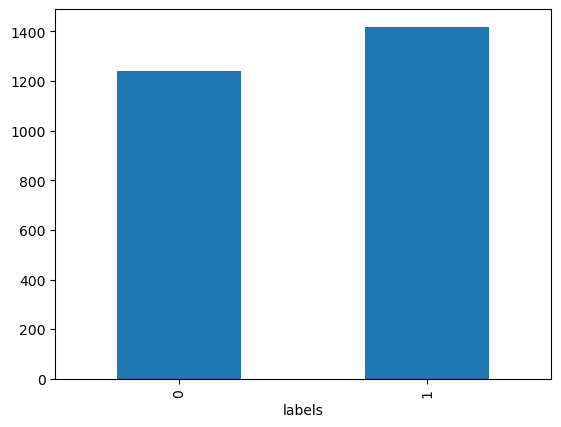

: 

In [47]:
test["binary_preds"] = binary_preds
test[test["labels"] != test["binary_preds"]].groupby('labels').count()["sentences"].plot(kind="bar")

In [32]:
pd.set_option('display.max_colwidth', None)
# test[test["labels"] != test["y_pred"]].sample(5)
indices = [27443, 29215, 14827 ,18809 ,12847]
test[test.index.isin(indices)]

,sentences,labels,binary_preds
12847,"a good book: this book really hit the mark with the right balance of theory and practical application. i've waded through more than a few technical books on tube radio theory and restoration, and this one, though not as detailed as a textbook, is clearly the place to start.however, the section on troubleshooting was extremely limited. experience indicates that after following the steps recommended in the book between 10 and 20 percent of restored radios will still have some type of problem. most individuals learning the process for repairing tube radios will be seeking practical guidance for identifying possible sources of these problems and their potential solutions. maybe troubleshooting will be the subject of mr. mcwhorter's next book.",1,1
14827,"here is just a sample!! check it out!!: i love this album and pray that someone contacts me so that i can get a copy of the cd or even tape! amazon...please get this so that all of us who would like a copy can get it! until then...here is ""feel like going on"" the song![...]",1,1
18809,"still in the box: i don't really know how the product is. after reading more detailed information included with the product, it says not recommended for the pool because the clorine could effect/shorten the product life. it seems that the ad shows the coolaroo shade being used next to the pool. and that's what we bought it for. not sure what to do with them now - still siting in the box next to the door gathering dust.... oh, well. i'm sure its a great product, just not for us.",0,0
27443,"leaves the readers hungry for more.: it's weird really how i got so into this book. one of my friends who just so happened read the book was begging me to read it. now, don't get me wrong i love fantasy stories especially ones that are about these blood suckers but after hearing my friend's summary of it i don't know i just felt uninterested.pffft...boy was i glad my friend's the persisting type. she practically lunged the book at me. so as to not annoy her more, i read her copy of the book and i found myself entralled by it. i could not stop reading it!after finishing it i felt saddened that it was finished. i wanted more! i wanted to know what happened next.i gave the book back to my friend and straight away got myself a copy of twilight. it's really that good. i love it.trust me no matter how 'off' the summary might seem like you would not feel dissatisfied by its contents.",1,0
29215,"emotionally-distant author: for a memoir, the author is very removed from the experiences she writes about. she conveys little if any emotion about what must have been a very lonely and often frightening existance (especially given her age) in a strange land with a mad and eventually abusive husband, a young child who was often extremely sick and with the responsibilites of running a hacienda. although her writing is beautiful at times, the author never really connected with me.",0,0


As we can see and also expect BERT model has succesfully predicted the most of the reviews where SVM with tf-idf failed. It matches with our intuition where we claimed that BERT transformers are better at capturing the context and semantics. BERT treats sentences as sequences which is advantage of the bidirectional context of words in a sentence. It uses the Transformer architecture to capture the contextual relationships between words by considering the surrounding words on both the left and right sides.

In the BERT model, sentences are tokenized into individual tokens, and each token is assigned a unique embedding. These tokens, along with special tokens like [CLS] (used for classification) and [SEP] (used to separate sentences), are then passed through the transformer layers for encoding.

The positional information of each token in the sequence is also encoded, allowing BERT to understand the sequential order of the tokens. This sequential understanding helps BERT capture the context and meaning of the sentences effectively.